In [40]:
import pandas as pd

from data_preprocessing import encode_categorical_features, transform_target_to_categorical
from sampling import create_train_test_sets, create_stratified_kfolds

from model_evaluation import evaluate_model
from visualization import plot_tree_based_model, plot_model_accuracy_for_epochs, \
    plot_model_loss_for_epochs, plot_acc_overview, plot_mcc_overview, plot_acc_per_ccp_alpha, plot_correlation_matrix
from feature_selection import exclude_correlated_features, exclude_low_variance_features, \
    select_features_using_information_gain, chi2_feature_selection

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [41]:
# notebook parameters
input_dataset_path = 'data/heart_disease_health_indicators_BRFSS2015.csv'
target_col = 'HeartDiseaseorAttack'

### Loading dataset

In [42]:
heart_df = pd.read_csv(input_dataset_path)
heart_df[target_col] = heart_df[target_col].astype(int)
heart_df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [43]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=[target_col]).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df[target_col].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 253680 rows and 22 colums
Input dataset consists of 21 features and 1 target column
Target values are: [0 1]
Input dataset contains 23899 duplicated rows and 229781 unique rows


In [44]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  int32  
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

### Data preprocessing

In [45]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

In [46]:
# encode categorical features using LabelEncoder and OneHotEncoding
heart_df = encode_categorical_features(heart_df, target_col)

Ordinal Categorical Features: []
Nominal Categorical Features: []


In [47]:
# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=[target_col])
y = heart_df[target_col]

In [48]:
# Transform target data sets into binary matrix representation of the target values
y_categorical = transform_target_to_categorical(target_df=y)

### Data stratified sampling

In [49]:
# Stratified sampling into 5 folds
n_splits=5
create_stratified_kfolds(x_df=x, y_df=y, dataset=heart_df, n_splits=n_splits)

5 Folds created and saved in the "folds" directory successfully


In [50]:
# Create empty lists to store train and test DataFrames
train_datasets = []
test_datasets = []

for fold_num in range(1, n_splits+1):
    train_file_path = f'folds/fold_{fold_num}_train.csv'
    test_file_path = f'folds/fold_{fold_num}_test.csv'
    
    # Load the train and test fold data into DataFrames
    train_fold = pd.read_csv(train_file_path)
    test_fold = pd.read_csv(test_file_path)
    
    train_datasets.append(train_fold)
    test_datasets.append(test_fold)

### Feature scaling

In [51]:
# # some models are sensitive for feature value scale differences
# # StandardScaler is used to transform those values into rescaled format, without information loss

# Create an instance of StandardScaler
scaler = StandardScaler()

# Create empty lists to store scaled training and testing DataFrames
scaled_train_datasets = []
scaled_test_datasets = []

# Loop through the folds, where each fold contains train and test DataFrames
for train_fold, test_fold in zip(train_datasets, test_datasets):
    # Separate features (X) and target (y)
    X_train = train_fold.drop(columns=[target_col])
    y_train = train_fold[target_col]
    X_test = test_fold.drop(columns=[target_col])
    y_test = test_fold[target_col]
    
    # Fit and transform on training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform on testing data using the mean and std from training data
    X_test_scaled = scaler.transform(X_test)
    
    # Create DataFrames with scaled features
    scaled_train_fold = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    scaled_test_fold = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    scaled_train_fold[target_col] = y_train
    scaled_test_fold[target_col] = y_test
    
    # Append the scaled DataFrames to the lists
    scaled_train_datasets.append(scaled_train_fold)
    scaled_test_datasets.append(scaled_test_fold)

### Feature selection based on training dataset

In [52]:
# Create empty lists to store selected feature DataFrames for each fold
selected_features_datasets = []

# Define the number of top features to select (for SelectKBest)
k_best_features = 10

# Define the number of features to select (for RFE)
num_features_to_select = 10

# Loop through the folds, where each fold contains scaled training and testing DataFrames
for scaled_train_fold, _ in zip(scaled_train_datasets, scaled_test_datasets):
    # Separate features (X) and target (y)
    X_train_scaled = scaled_train_fold.drop(columns=[target_col])
    y_train = scaled_train_fold[target_col]
    
    # Initialize feature selection methods
    k_best_selector = SelectKBest(k=k_best_features)
    rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=num_features_to_select)
    sfm_selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100))
    
    # Fit and transform with SelectKBest
    X_train_k_best = k_best_selector.fit_transform(X_train_scaled, y_train)
    
    # Fit and transform with RFE
    X_train_rfe = rfe_selector.fit_transform(X_train_scaled, y_train)
    
    # Fit and transform with SelectFromModel
    X_train_sfm = sfm_selector.fit_transform(X_train_scaled, y_train)
    
    # Create DataFrames with selected features
    selected_features_datasets.append({
        'SelectKBest': pd.DataFrame(X_train_k_best),
        'RFE': pd.DataFrame(X_train_rfe),
        'SelectFromModel': pd.DataFrame(X_train_sfm)
    })

### Decision Tree

In [ ]:
# TODO crate pipeline with components of specific models to run in for separate folds!

In [ ]:
# Select training and test datasets
x_train, x_test, y_train, y_test = create_train_test_sets(x_df=x, y_df=y, test_size=0.25)

Accuracy: 72.37%
Precision: 72.73%
Recall: 78.05%
F1-score: 0.75
Matthews Correlation Coefficient (MCC): 0.44
RMSE: 0.53
R Squared: -0.11
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        35
           1       0.73      0.78      0.75        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



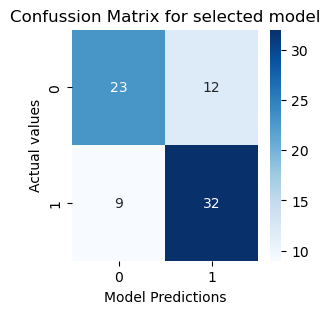

In [10]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)
dt_acc, dt_mcc = evaluate_model(dt_model, x_test=x_test, y_test=y_test)

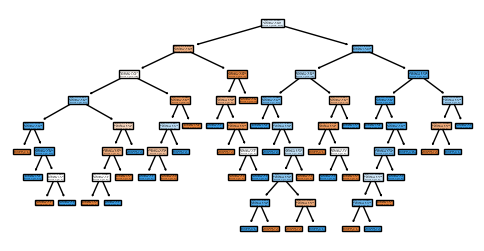

In [11]:
plot_tree_based_model(dt_model)

### Pruning Decision Tree

In [12]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [13]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [14]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} node for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 node for cpp_alpha parameter 0.21982887346468272


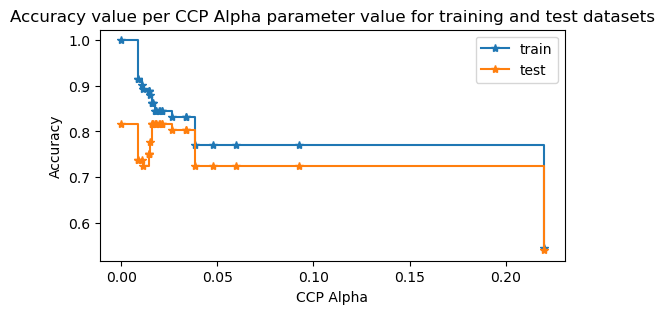

In [15]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

plot_acc_per_ccp_alpha(ccp_alphas, train_scores, test_scores)

Accuracy: 75.0%
Precision: 77.5%
Recall: 75.61%
F1-score: 0.77
Matthews Correlation Coefficient (MCC): 0.5
RMSE: 0.5
R Squared: -0.01
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        35
           1       0.78      0.76      0.77        41

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



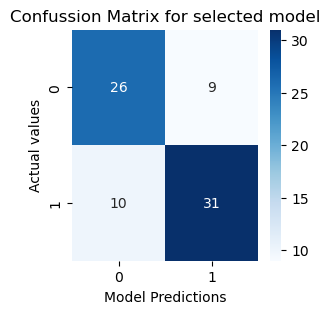

In [16]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.02, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)
pdt_acc, pdt_mcc = evaluate_model(pdt_model, x_test=x_test, y_test=y_test)

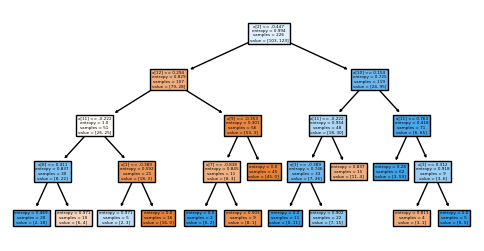

In [17]:
plot_tree_based_model(pdt_model)

### Random Forest

In [18]:
rf_base_model = RandomForestClassifier(random_state=0)
n_estimators = [10, 25, 50, 100, 250]
max_depth = [3, 5, 8, 10, 15]
max_features = ["sqrt", "log2", None, 0.5]
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features
}

gsearch = GridSearchCV(rf_base_model,
                       param_grid=params,
                       scoring='recall')
gsearch.fit(x_train, y_train)
print(f'The best score is : {gsearch.best_score_}')
print(f'The best estimator is : {gsearch.best_estimator_}')
print(f'The best parameters is : {gsearch.best_params_}')

The best score is : 0.8793333333333333
The best estimator is : RandomForestClassifier(max_depth=3, n_estimators=25, random_state=0)
The best parameters is : {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 25}


Accuracy: 82.89%
Precision: 81.82%
Recall: 87.8%
F1-score: 0.85
Matthews Correlation Coefficient (MCC): 0.66
RMSE: 0.41
R Squared: 0.31
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        35
           1       0.82      0.88      0.85        41

    accuracy                           0.83        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.83      0.83      0.83        76



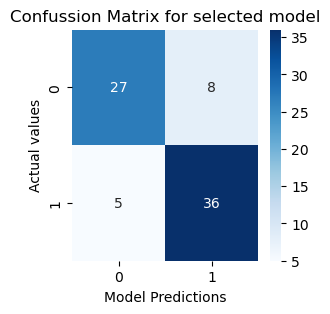

In [19]:
rf_model = RandomForestClassifier(n_estimators=25,
                                  max_features='sqrt',
                                  random_state=0,
                                  max_depth=3)

rf_model.fit(x_train, y_train)
rf_acc, rf_mcc = evaluate_model(rf_model, x_test=x_test, y_test=y_test)

### CNN model

In [20]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [21]:
cnn_model.fit(x_train, 
              y_cat_train, 
              epochs=10, 
              validation_data=(x_test, y_cat_test))

Epoch 1/10
8/8 [==============================] - 3s 88ms/step - loss: 0.5780 - accuracy: 0.6903 - val_loss: 0.4505 - val_accuracy: 0.8553
Epoch 2/10
8/8 [==============================] - 0s 16ms/step - loss: 0.3748 - accuracy: 0.8496 - val_loss: 0.3910 - val_accuracy: 0.8553
Epoch 3/10
8/8 [==============================] - 0s 15ms/step - loss: 0.3379 - accuracy: 0.8540 - val_loss: 0.3896 - val_accuracy: 0.8553
Epoch 4/10
8/8 [==============================] - 0s 15ms/step - loss: 0.3187 - accuracy: 0.8540 - val_loss: 0.4077 - val_accuracy: 0.8553
Epoch 5/10
8/8 [==============================] - 0s 15ms/step - loss: 0.2928 - accuracy: 0.8717 - val_loss: 0.4222 - val_accuracy: 0.8421
Epoch 6/10
8/8 [==============================] - 0s 16ms/step - loss: 0.2782 - accuracy: 0.8938 - val_loss: 0.4357 - val_accuracy: 0.8421
Epoch 7/10
8/8 [==============================] - 0s 15ms/step - loss: 0.2623 - accuracy: 0.8717 - val_loss: 0.4415 - val_accuracy: 0.8684
Epoch 8/10
8/8 [===========

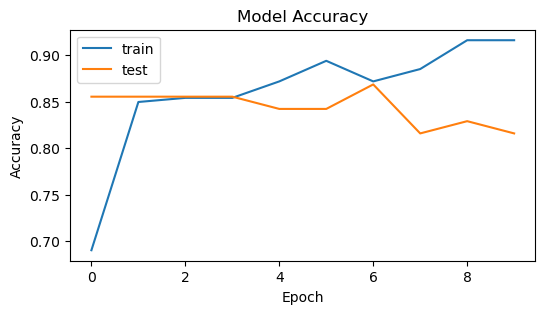

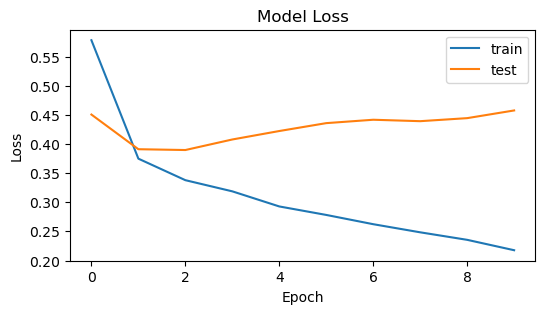

In [22]:
plot_model_accuracy_for_epochs(cnn_model)
plot_model_loss_for_epochs(cnn_model)

In [23]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_cat_train)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_cat_test)}")

8/8 [==============================] - 0s 2ms/step - loss: 0.2026 - accuracy: 0.9115
CNN model evaluation after training: [0.20264767110347748, 0.9115044474601746]
3/3 [==============================] - 0s 7ms/step - loss: 0.4575 - accuracy: 0.8158
CNN model evaluation for test dataset: [0.4574981927871704, 0.8157894611358643]


3/3 [==============================] - 0s 4ms/step
Accuracy: 81.58%
Precision: 81.4%
Recall: 85.37%
F1-score: 0.83
Matthews Correlation Coefficient (MCC): 0.63
RMSE: 0.43
R Squared: 0.26
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        35
           1       0.81      0.85      0.83        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.82        76



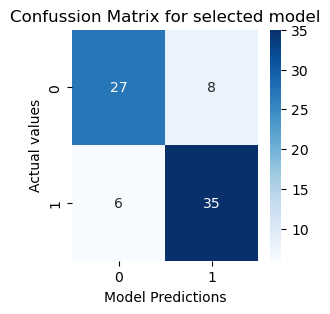

In [24]:
cnn_acc, cnn_mcc = evaluate_model(cnn_model, x_test=x_test, y_test=y_test, is_cnn=True)

### Logistic Regression

Accuracy: 85.53%
Precision: 82.61%
Recall: 92.68%
F1-score: 0.87
Matthews Correlation Coefficient (MCC): 0.71
RMSE: 0.38
R Squared: 0.42
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.83      0.93      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



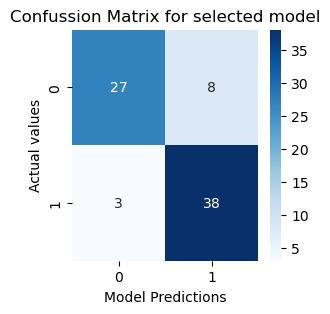

In [25]:
lr_model = LogisticRegression(random_state=0, C=10, penalty='l2')
lr_model.fit(x_train, y_train)
lr_acc, lr_mcc = evaluate_model(lr_model, x_test=x_test, y_test=y_test)

### Support Vector Machine

Accuracy: 86.84%
Precision: 82.98%
Recall: 95.12%
F1-score: 0.89
Matthews Correlation Coefficient (MCC): 0.74
RMSE: 0.36
R Squared: 0.47
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        35
           1       0.83      0.95      0.89        41

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.87        76
weighted avg       0.88      0.87      0.87        76



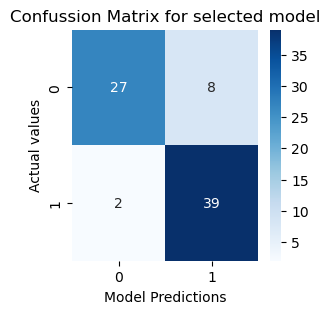

In [26]:
svm_model = SVC(kernel='linear', C=0.3)
svm_model.fit(x_train, y_train)
svm_acc, svm_mcc = evaluate_model(svm_model, x_test=x_test, y_test=y_test)

### K Nearest Neighbours

Accuracy: 84.21%
Precision: 83.72%
Recall: 87.8%
F1-score: 0.86
Matthews Correlation Coefficient (MCC): 0.68
RMSE: 0.4
R Squared: 0.36
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



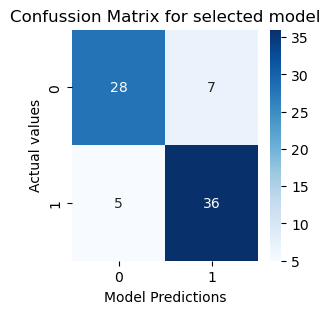

In [27]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_acc, knn_mcc = evaluate_model(knn_model, x_test=x_test, y_test=y_test)

### Gaussian Naive Bayes

Accuracy: 81.58%
Precision: 80.0%
Recall: 87.8%
F1-score: 0.84
Matthews Correlation Coefficient (MCC): 0.63
RMSE: 0.43
R Squared: 0.26
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        35
           1       0.80      0.88      0.84        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.81        76



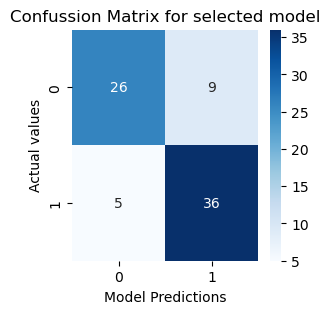

In [28]:
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)
gnb_acc, gnb_mcc = evaluate_model(gnb_model, x_test=x_test, y_test=y_test)

### XGBoost Classifier

Accuracy: 76.32%
Precision: 79.49%
Recall: 75.61%
F1-score: 0.77
Matthews Correlation Coefficient (MCC): 0.53
RMSE: 0.49
R Squared: 0.05
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.79      0.76      0.77        41

    accuracy                           0.76        76
   macro avg       0.76      0.76      0.76        76
weighted avg       0.76      0.76      0.76        76



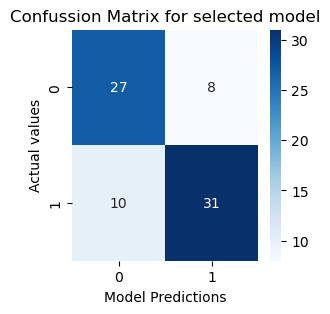

In [29]:
xgb_model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
xgb_model.fit(x_train, y_train)
xgb_acc, xgb_mcc = evaluate_model(xgb_model, x_test=x_test, y_test=y_test)

Accuracy: 84.21%
Precision: 83.72%
Recall: 87.8%
F1-score: 0.86
Matthews Correlation Coefficient (MCC): 0.68
RMSE: 0.4
R Squared: 0.36
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



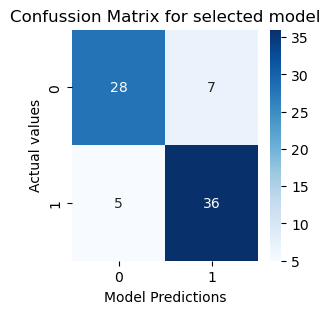

In [30]:
cb_model = CatBoostClassifier(verbose=False)
cb_model.fit(x_train, y_train)
cb_acc, cb_mcc = evaluate_model(cb_model, x_test=x_test, y_test=y_test)

### LightGBM Classifier

In [31]:
# lgbm_model = LGBMClassifier()
# lgbm_model.fit(x_train, y_train)
# lgbm_acc, lgb,_mcc = evaluate_model(lgbm_model, x_test=x_test, y_test=y_test)

### Comparison of models' results

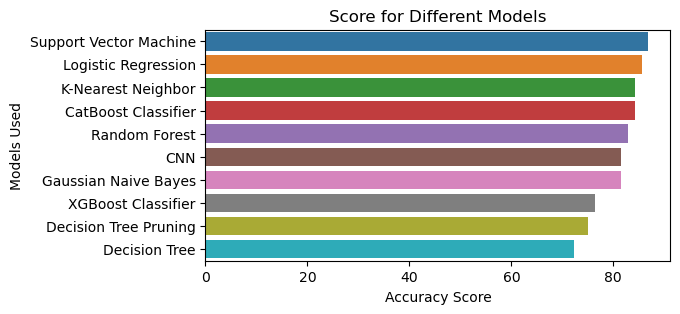

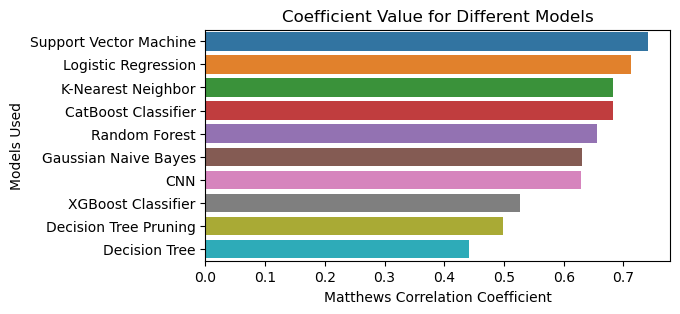

In [32]:
acc_scores = {
    'Decision Tree': dt_acc * 100, 
    'Decision Tree Pruning': pdt_acc * 100, 
    'Random Forest': rf_acc * 100, 
    'Logistic Regression': lr_acc * 100,
    'Support Vector Machine': svm_acc * 100, 
    'K-Nearest Neighbor': knn_acc * 100,
    'CNN': cnn_acc * 100,
    'Gaussian Naive Bayes': gnb_acc * 100,
    'XGBoost Classifier': xgb_acc * 100,
    'CatBoost Classifier': cb_acc * 100
}

mcc_scores = {
    'Decision Tree': dt_mcc, 
    'Decision Tree Pruning': pdt_mcc, 
    'Random Forest': rf_mcc, 
    'Logistic Regression': lr_mcc,
    'Support Vector Machine': svm_mcc, 
    'K-Nearest Neighbor': knn_mcc,
    'CNN': cnn_mcc,
    'Gaussian Naive Bayes': gnb_mcc,
    'XGBoost Classifier': xgb_mcc,
    'CatBoost Classifier': cb_mcc
}

plot_acc_overview(acc_scores)
plot_mcc_overview(mcc_scores)